In [3]:
import sys
import os
sys.path.append(os.path.abspath("../code"))

In [4]:
import create_data
import kmeans
import voltage
import os
import importlib
import time
import bpf
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

ModuleNotFoundError: No module named 'ijson'

In [3]:
importlib.reload(create_data)
importlib.reload(kmeans)
importlib.reload(voltage)
importlib.reload(bpf)

<module 'bpf' from 'C:\\Users\\avigh\\Documents\\python\\VoltageDimentionalReduction\\code\\bpf.py'>

In [5]:
import kagglehub

path = kagglehub.dataset_download("thanakomsn/glove6b300dtxt")

print(path)

C:\Users\avigh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\avigh\.cache\kagglehub\datasets\thanakomsn\glove6b300dtxt\versions\1


In [6]:
def load_glove_vectors(filepath, max_words=100000):
    word2vec = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_words:
                break
            parts = line.strip().split()
            word = parts[0]
            vector = list(map(float, parts[1:]))
            word2vec[word] = vector
    return word2vec

# Example
glove_path = path + "/glove.6B.300d.txt"  # or 300d
glove_vectors = load_glove_vectors(glove_path, max_words=1000)

In [7]:
len(glove_vectors)

1000

In [8]:
!ls -lh $path


total 990M
-rw-r--r-- 1 avigh 197611 990M May  2 13:31 glove.6B.300d.txt


In [9]:
words = list(glove_vectors.keys())
vectors = [glove_vectors[word] for word in words]
data = create_data.Data(vectors)

In [10]:
import random

# landmark_words = [words[int(random.random() * len(vectors))] for x in range(3)]
landmark_words = ["world", "country", "china"]

landmarks = []
for word in landmark_words:
    landmarks.append(voltage.Landmark(words.index(word), 1))

print(len(data))
print([l.index for l in landmarks])
print(landmark_words)

1000
[85, 123, 132]
['world', 'country', 'china']


In [84]:
cs = []
pgs = []

param_finder = bpf.BestParameterFinder()
param_finder.setKernelParameter(2e7)
# param_finder.setResistanceToGround(0.1)

for landmark in landmarks:
     c, p_g = param_finder.bestParameterFinder([landmark], data, minBound=-50, maxBound=20, granularity=20, epsilon=0.01, approx=100)
     print(c, p_g)
     cs.append(c)
     pgs.append(p_g)

19999999.999999978 7.681204685202095e-15
19999999.999999978 1.1099189036438807e-21
19999999.999999978 1.1099189036438807e-21


In [111]:
voltages = []

for index in range(0, len(landmarks)):
    problem = voltage.Problem(data)
    problem.setKernel(problem.gaussiankernel)
    problem.setWeights(cs[index])
    problem.addLandmark(landmarks[index])
    problem.addUniversalGround(pgs[index])
    voltages.append(voltage.Solver(problem).approximate_voltages(max_iters=100))

In [112]:
# voltage_matrix = np.stack(voltages, axis=1)  # shape: (n_points, 3)

# max_diffs = np.max(voltage_matrix, axis=1) - np.min(voltage_matrix, axis=1)

# sorted_indices = np.argsort(max_diffs)
# n_remove = int(len(sorted_indices) * 0.8)
# indices_to_remove = sorted_indices[:n_remove]

# print([words[idx] for idx in indices_to_remove])

In [113]:
# # Step 1: Stack voltages into shape (n, 3)
# voltage_matrix = np.stack(voltages, axis=1)  # shape: (n_points, 3)

# # Step 2: Compute max absolute difference for each point across the 3 voltages
# max_diffs = np.max(voltage_matrix, axis=1) - np.min(voltage_matrix, axis=1)

# # Step 3: Find indices where voltages are close (small max diff)
# sorted_indices = np.argsort(max_diffs)
# n_remove = len(sorted_indices) // 2
# indices_to_remove = sorted_indices[:n_remove]

# # Step 4: Mask out these indices from data and landmarks
# keep_indices = np.setdiff1d(np.arange(len(data)), indices_to_remove)

# # You’ll need to update data and landmarks accordingly
# filtered_data = data.getSubSet(keep_indices)  # Assuming data supports a subset method

# # Then rerun the voltage calculation on filtered_data
# voltages = []
# for index in range(0, len(landmarks)):
#     problem = voltage.Problem(filtered_data)
#     problem.setKernel(problem.gaussiankernel)
#     problem.setWeights(cs[index])
#     problem.addLandmark(landmarks[index])
#     problem.addUniversalGround(pgs[index])
#     voltages.append(voltage.Solver(problem).approximate_voltages(max_iters=100))

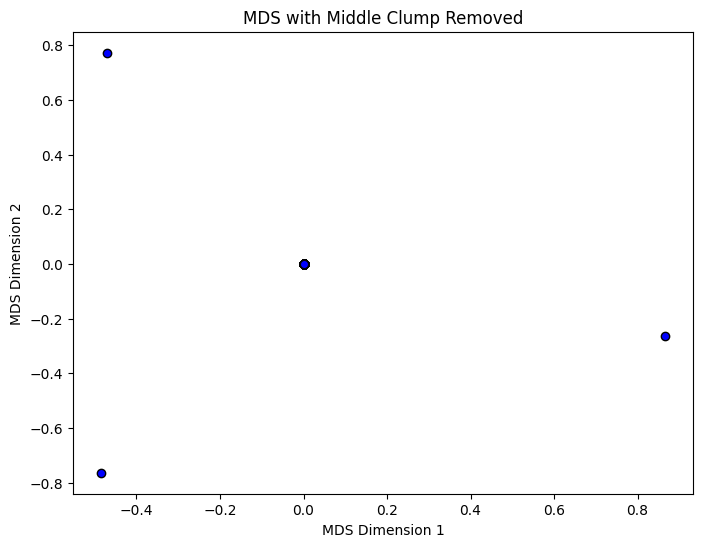

<Figure size 640x480 with 0 Axes>

In [114]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Example: compute MDS first
mds = MDS(n_components=2, random_state=42)
transformed_points = mds.fit_transform(points)

# Compute the centroid
centroid = np.median(transformed_points, axis=0)

# Compute distance from each point to the centroid
distances = np.linalg.norm(transformed_points - centroid, axis=1)

# Define a threshold (tune this!)
threshold = np.percentile(distances, 50)  # remove ~30% most centered
mask = distances > threshold

# Filter points
transformed_points = transformed_points[mask]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='blue', edgecolors='black')
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("MDS with Middle Clump Removed")
plt.show()
plt.clf()

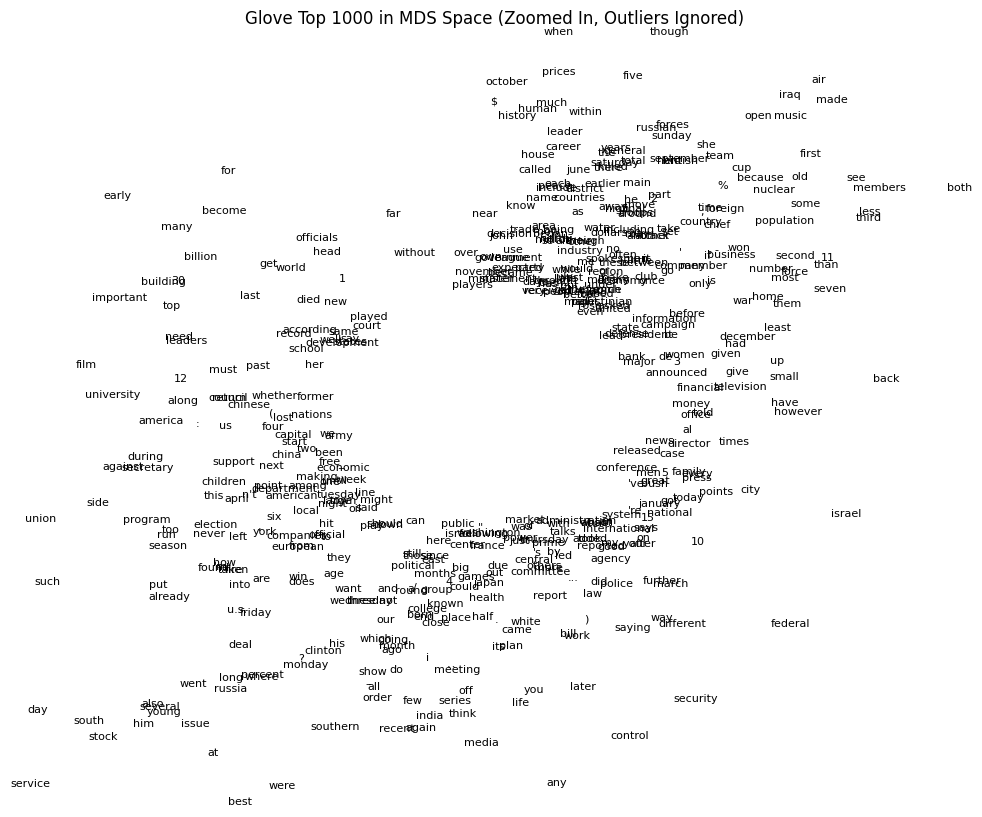

In [116]:
# Step 1: Calculate distances from the mean (or median) of all points
center = np.mean(transformed_points, axis=0)
distances = np.linalg.norm(transformed_points - center, axis=1)

# Step 2: Find the indices of the 10 most distant points
outlier_indices = np.argsort(distances)[-10:]

# Step 3: Get the mask of inliers (non-outliers)
mask = np.ones(len(transformed_points), dtype=bool)
mask[outlier_indices] = False

# Step 4: Get the non-outlier (central cluster) points
inlier_points = transformed_points[mask]

# Plot with zoom-in
fig, ax = plt.subplots(figsize=(12, 10))
for i in np.where(mask)[0]:
    ax.text(transformed_points[i, 0], transformed_points[i, 1], str(words[i]),
            color='black', fontsize=8, alpha=1,
            ha='center', va='center')

# Set axis limits based on inlier points
ax.set_xlim(inlier_points[:, 0].min(), inlier_points[:, 0].max())
ax.set_ylim(inlier_points[:, 1].min(), inlier_points[:, 1].max())

plt.axis('off')
plt.title("Glove Top 1000 in MDS Space (Zoomed In, Outliers Ignored)")
plt.savefig("../inputoutput/matplotfigures/glovemdsremoved.png")
plt.show()